In [1]:
import numpy as np
import pandas as pd

In [2]:
from tqdm.auto import tqdm
tqdm.pandas()

/home/daniel/miniconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('parma_crescent_prices.csv')

In [4]:
df.dateSold = pd.to_datetime(df.dateSold)

In [5]:
df = df.sort_values('dateSold').reset_index(drop=True)

In [6]:
df['daysSince'] = df.dateSold - df.groupby('address').dateSold.shift()

In [7]:
import seaborn as sns

<Axes: xlabel='dateSold', ylabel='numericPrice'>

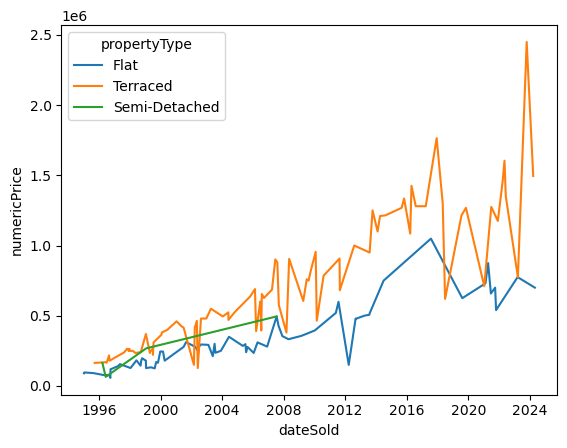

In [8]:
sns.lineplot(data=df, x='dateSold', y='numericPrice', hue='propertyType')

In [9]:
address_to_idx = {address: i for i, address in enumerate(df.address.sort_values().drop_duplicates())}
df['address_idx'] = df.address.apply(lambda x: address_to_idx[x])

In [10]:
import torch

price_tensor = torch.tensor(np.atleast_2d(df.numericPrice.head(-1).to_numpy().reshape(len(df.index)-1, 1)), dtype=torch.float32).to('cuda:0')
address_tensor = torch.tensor(np.atleast_2d(df.address_idx.tail(-1).to_numpy().reshape(len(df.index)-1, 1))).to('cuda:0')
y_tensor = torch.tensor(np.atleast_2d(df.numericPrice.tail(-1).to_numpy().reshape(len(df.index)-1, 1)), dtype=torch.float32).to('cuda:0')

In [11]:
address_tensor.shape, price_tensor.shape, y_tensor.shape

(torch.Size([161, 1]), torch.Size([161, 1]), torch.Size([161, 1]))

In [12]:
price_mean = price_tensor.mean()
price_std = price_tensor.std()

In [13]:
price_tensor = (price_tensor - price_mean) / price_std
y_tensor = (y_tensor - price_mean) / price_std

In [14]:
import torch.nn as nn

class MaskedLSTMModel(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super(MaskedLSTMModel, self).__init__()
        self.embeddings = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(1, hidden_size)
        self.fc = nn.Linear(embedding_size + hidden_size, output_size)

    def forward(self, addresses, prices):

        out, _ = self.lstm(prices)
        embeds = self.embeddings(addresses).view(len(addresses), -1)
        concat = torch.concat([out, embeds], axis=1)
        out = self.fc(concat)
        return out

In [15]:
INPUT_SIZE = len(address_tensor.unique())
EMBEDDING_SIZE = 1
HIDDEN_SIZE = 1
OUTPUT_SIZE = 1

In [16]:
import torch.optim as optim
import torch.nn.functional as F

model = MaskedLSTMModel(INPUT_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to('cuda:0')
loss_function = nn.NLLLoss().to('cuda:0')
optimizer = optim.SGD(model.parameters(), lr=0.01)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    pred = model(address_tensor, price_tensor)
    #print(pred)

losses = []
def inter_epoch(i):  # again, normally you would NOT do 300 epochs, it is toy data
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()

    # Step 2. Get our inputs ready for the network, that is, turn them into
    # Tensors of word indices.
    #sentence_in = prepare_sequence(sentence, word_to_ix)
    #targets = prepare_sequence(tags, tag_to_ix)

    # Step 3. Run our forward pass.
    pred = model(address_tensor, price_tensor)
    
    # Step 4. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = F.mse_loss(pred, y_tensor)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if i % 10000 == 9999: 
        ax = sns.lineplot(losses)
        ax.set(yscale='log')
        fig = ax.get_figure()
        fig.savefig('losses.png')
        fig.clf()
        pred = (pred.detach() * price_std) + price_mean
        ax = sns.lineplot(pred.to('cpu'), legend=None)
        fig = ax.get_figure()
        fig.savefig('pred.png')
        fig.clf()

pd.Series(range(100000)).progress_apply(inter_epoch)

# See what the scores are after training
with torch.no_grad():
    pred = model(address_tensor, price_tensor)
    #print(pred)


100%|█████████████████████████████████| 100000/100000 [01:20<00:00, 1246.53it/s]


<Figure size 640x480 with 0 Axes>

[None]

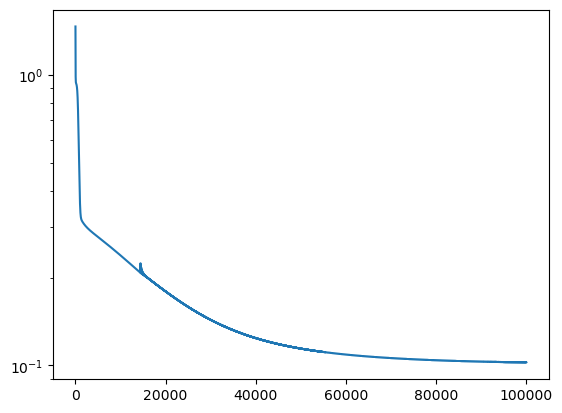

In [17]:
sns.lineplot(losses).set(yscale='log')

In [18]:
y_tensor = (y_tensor.detach() * price_std) + price_mean

<Axes: >

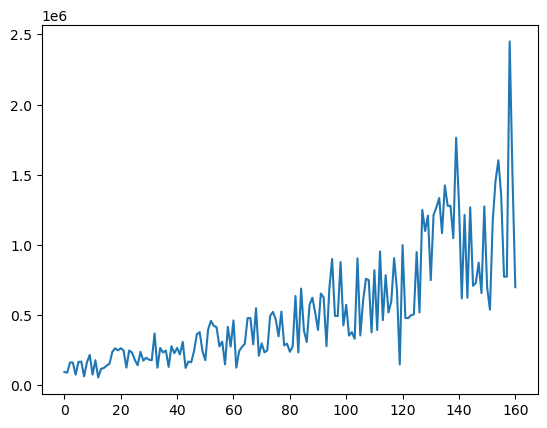

In [19]:
sns.lineplot(y_tensor.to('cpu'), legend=None)

In [20]:
pred = (pred.detach() * price_std) + price_mean

<Axes: >

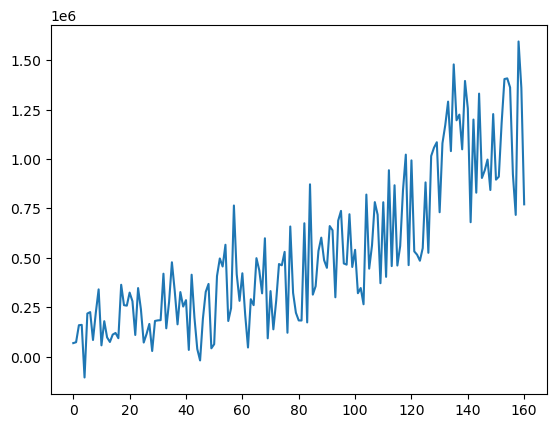

In [21]:
sns.lineplot(pred.to('cpu'), legend=None)

In [22]:
df_plot = df.join(pd.DataFrame(pred.to('cpu'), index=df.tail(-1).index, columns=['predPrice']))

In [23]:
df_plot[df_plot.address=='55, Parma Crescent, London, Greater London SW11 1LU']

,address,propertyType,images,hasFloorPlan,location,detailUrl,bedrooms,displayPrice,dateSold,tenure,newBuild,numericPrice,address_1,address_2,number,postcode,prefix,daysSince,address_idx,predPrice
2,"55, Parma Crescent, London, Greater London SW1...",Flat,{'imageUrl': 'https://media.rightmove.co.uk/di...,False,"{'lat': 51.4622, 'lng': -0.16433}",https://www.rightmove.co.uk/house-prices/detai...,2.0,"£91,200",1995-08-18,Leasehold,False,91200,Parma Crescent,London,55,SW11 1LU,NaN,NaT,32,72767.1250
30,"55, Parma Crescent, London, Greater London SW1...",Flat,{'imageUrl': 'https://media.rightmove.co.uk/di...,False,"{'lat': 51.4622, 'lng': -0.16433}",https://www.rightmove.co.uk/house-prices/detai...,2.0,"£197,500",1998-10-16,Leasehold,False,197500,Parma Crescent,London,55,SW11 1LU,NaN,1155 days,32,180399.8125
71,"55, Parma Crescent, London, Greater London SW1...",Flat,{'imageUrl': 'https://media.rightmove.co.uk/di...,False,"{'lat': 51.4622, 'lng': -0.16433}",https://www.rightmove.co.uk/house-prices/detai...,2.0,"£300,000",2003-07-04,Leasehold,False,300000,Parma Crescent,London,55,SW11 1LU,NaN,1722 days,32,331663.9375


<Axes: xlabel='dateSold', ylabel='predPrice'>

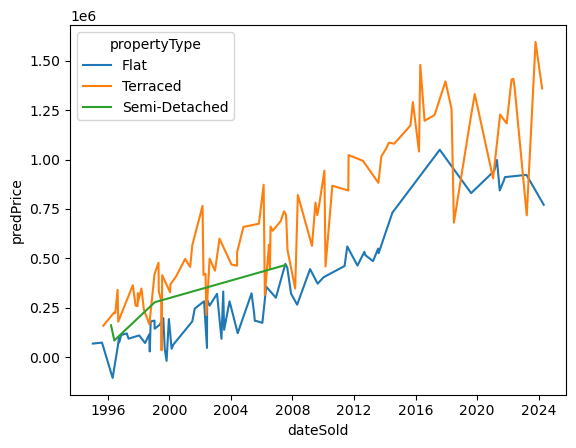

In [24]:
sns.lineplot(data=df_plot, x='dateSold', y='predPrice', hue='propertyType')

<Axes: xlabel='numericPrice', ylabel='predPrice'>

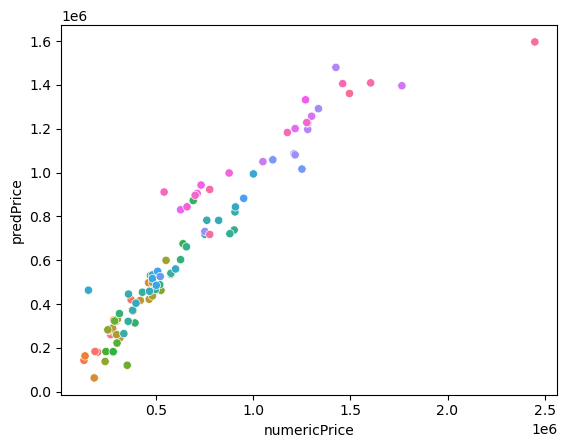

In [25]:
sns.scatterplot(data=df_plot, x='numericPrice', y='predPrice', hue='daysSince', legend=False)

In [26]:
[(address, (model(
    torch.cat([address_tensor, torch.tensor([[address_to_idx[address]]]).to('cuda:0')]), 
    (torch.tensor([df.numericPrice.tolist()], dtype=torch.float32).T.to('cuda:0') - price_mean) / price_std
)[-1].item() * price_std) + price_mean) for address in address_to_idx]

[('10, Parma Crescent, London, Greater London SW11 1LT',
  tensor(913406., device='cuda:0')),
 ('12, Parma Crescent, London, Greater London SW11 1LT',
  tensor(1161063.2500, device='cuda:0')),
 ('13, Parma Crescent, London, Greater London SW11 1LT',
  tensor(1232587.1250, device='cuda:0')),
 ('15, Parma Crescent, London, Greater London SW11 1LT',
  tensor(1101607.7500, device='cuda:0')),
 ('16, Parma Crescent, London, Greater London SW11 1LT',
  tensor(1415913.7500, device='cuda:0')),
 ('17, Parma Crescent, London, Greater London SW11 1LT',
  tensor(1376599.2500, device='cuda:0')),
 ('18, Parma Crescent, London, Greater London SW11 1LT',
  tensor(1167005.2500, device='cuda:0')),
 ('20, Parma Crescent, London, Greater London SW11 1LT',
  tensor(1316808.7500, device='cuda:0')),
 ('21, Parma Crescent, London, Greater London SW11 1LT',
  tensor(1378346.5000, device='cuda:0')),
 ('22, Parma Crescent, London, Greater London SW11 1LT',
  tensor(1269902., device='cuda:0')),
 ('25, Parma Cresce

In [27]:
df_plot

,address,propertyType,images,hasFloorPlan,location,detailUrl,bedrooms,displayPrice,dateSold,tenure,newBuild,numericPrice,address_1,address_2,number,postcode,prefix,daysSince,address_idx,predPrice
0,"27a, Parma Crescent, London, Greater London SW...",Flat,{'imageUrl': 'https://media.rightmove.co.uk/di...,True,"{'lat': 51.4623, 'lng': -0.1649}",https://www.rightmove.co.uk/house-prices/detai...,2.0,"£89,950",1995-01-05,Leasehold,False,89950,Parma Crescent,London,27a,SW11 1LT,NaN,NaT,14,NaN
1,"45b, Parma Crescent, London, Greater London SW...",Flat,{'imageUrl': 'https://media.rightmove.co.uk/di...,False,"{'lat': 51.4623, 'lng': -0.1649}",https://www.rightmove.co.uk/house-prices/detai...,2.0,"£96,080",1995-01-12,Leasehold,False,96080,Parma Crescent,London,45b,SW11 1LT,NaN,NaT,27,6.811844e+04
2,"55, Parma Crescent, London, Greater London SW1...",Flat,{'imageUrl': 'https://media.rightmove.co.uk/di...,False,"{'lat': 51.4622, 'lng': -0.16433}",https://www.rightmove.co.uk/house-prices/detai...,2.0,"£91,200",1995-08-18,Leasehold,False,91200,Parma Crescent,London,55,SW11 1LU,NaN,NaT,32,7.276712e+04
3,"52, Parma Crescent, London, Greater London SW1...",Terraced,{'imageUrl': 'https://media.rightmove.co.uk/di...,True,"{'lat': 51.4623, 'lng': -0.1649}",https://www.rightmove.co.uk/house-prices/detai...,3.0,"£164,000",1995-09-18,Freehold,False,164000,Parma Crescent,London,52,SW11 1LT,NaN,NaT,31,1.587856e+05
4,"12, Parma Crescent, London, Greater London SW1...",Semi-Detached,{'imageUrl': '/spw/images/placeholder/no-image...,False,"{'lat': 51.4623, 'lng': -0.1649}",https://www.rightmove.co.uk/house-prices/detai...,NaN,"£163,200",1996-03-19,Freehold,False,163200,Parma Crescent,London,12,SW11 1LT,NaN,NaT,1,1.606062e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,"Flat B, 73, Parma Crescent, London, Greater Lo...",Flat,{'imageUrl': 'https://media.rightmove.co.uk/di...,True,"{'lat': 51.4622, 'lng': -0.16433}",https://www.rightmove.co.uk/house-prices/detai...,1.0,"£775,000",2023-03-17,Leasehold,False,775000,Parma Crescent,London,73,SW11 1LU,Flat B,3847 days,51,9.226046e+05
158,"60, Parma Crescent, London, Greater London SW1...",Terraced,{'imageUrl': 'https://media.rightmove.co.uk/di...,True,"{'lat': 51.4622, 'lng': -0.16433}",https://www.rightmove.co.uk/house-prices/detai...,2.0,"£775,000",2023-03-24,Freehold,False,775000,Parma Crescent,London,60,SW11 1LU,NaN,1729 days,36,7.174783e+05
159,"76, Parma Crescent, London, Greater London SW1...",Terraced,{'imageUrl': 'https://media.rightmove.co.uk/di...,True,"{'lat': 51.4622, 'lng': -0.16433}",https://www.rightmove.co.uk/house-prices/detai...,5.0,"£2,450,000",2023-10-19,Freehold,False,2450000,Parma Crescent,London,76,SW11 1LU,NaN,2736 days,47,1.595822e+06
160,"43, Parma Crescent, London, Greater London SW1...",Terraced,{'imageUrl': 'https://media.rightmove.co.uk/di...,True,"{'lat': 51.46221, 'lng': -0.16476}",https://www.rightmove.co.uk/house-prices/detai...,4.0,"£1,495,000",2024-03-22,Freehold,False,1495000,Parma Crescent,London,43,SW11 1LT,NaN,6125 days,25,1.360592e+06
